# Several Classification Methods Comparison

This notebook would implement several machine learning methods:

- Logistic Regression
- Decision Trees
- Random Forest
- Neural Networks: we will use Multi-layer perceptron.

We will illustrate them and compare their performances on an example of binary classification: **Indian Liver Patient Records**. 

In this notebook, you will learn:

- How to preprocess your data to prepare for training ML models.
- How to train your ML models based on cross-validation.
- How to evaluate your ML models based on testing data.
- How to plot some comparison results such as ROC curve.

**------------------NEW-------------------**

This notebook adds `Model Inspection` section 

- To visualize `Partial dependence plots` (PDP) to understand how a feature affects predictions.

- To visualize `Permutation Feature Importance` to understand what features have the biggest impact on predictions.


# Libraries

We will be comparing machine learning methods using a few different `sklearn` algorithms.

In [1]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.pipeline import Pipeline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Data Processing

## Load Data

**Indian Liver Patient Records**

This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records.

Any patient whose age exceeded 89 is listed as being of age "90".

Columns:

- Age of the patient
- Gender of the patient
- Total Bilirubin
- Direct Bilirubin
- Alkaline Phosphotase
- Alamine Aminotransferase
- Aspartate Aminotransferase
- Total Protiens
- Albumin
- Albumin and Globulin Ratio
- Dataset: field used to split the data into two sets (patient with liver disease (value = 2), or no disease (value = 1))


In [2]:
# Load data
initial_data = pd.read_csv('indian_liver_patient.csv')

In [3]:
# Look at the first 5 rows
initial_data.head(n=5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,2
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,2
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,2
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,2
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,2


In [4]:
# information of the data: 583 data points, 10 features' columns and 1 target column
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## Tidy Data

### Check missing values
First, we should check if there are missing values in the dataset. We could see that four patients do not have the value of `Albumin_and_Globulin_Ratio`.

In [5]:
# check if there are Null values
initial_data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. Actually, there exists some strategies to impute missing values (see [here](https://scikit-learn.org/stable/modules/impute.html)). For simplicity, we will discard the four rows with missing values. 

In [6]:
# Discard the rows with missing values
data_to_use = initial_data.dropna()

# Shape of the data: we could see that the number of rows is 579 now (originally it is 583)
data_to_use.shape

(579, 11)

In [7]:
# check if there are Null values
data_to_use.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

### Check imbalanced issue on y

First, we get the `X` and `y`.

In [8]:
X = data_to_use.drop(axis=1, columns=['Dataset']) # X is a dataframe

y = data_to_use['Dataset'].values # y is an array

In [9]:
# Calculate Y ratio
def data_ratio(y):
    '''
    Calculate Y's ratio
    '''
    unique, count = np.unique(y, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

The class ratio for the original data: 0.4:1 (165/414)


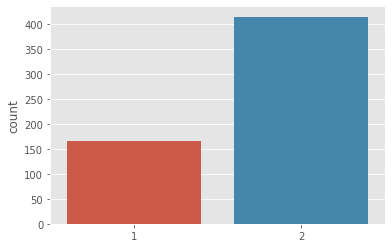

In [10]:
print('The class ratio for the original data:', data_ratio(y))
sns.countplot(y,label="Sum")
plt.show()

We could see that the dataset is not perfectly balanced. There are some sampling techniques to deal with this issue. Here, we ignore this issue because we are aimed to implement several ML models to compare their performance. 

### Split training and testing data

It is important to split `X` and `y` as training set and testing set. Here, we will split the original data as 70% training set and 30% testing set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=X['Gender'])

In [12]:
print('The class ratio in training data: ', data_ratio(y_train))
print('The class ratio in testing data: ', data_ratio(y_test))

The class ratio in training data:  0.3:1 (102/303)
The class ratio in testing data:  0.6:1 (63/111)


### Transform training and testing data

#### Transformation on X_train, X_test

Scikit-learn provides a library of transformers. Like other estimators, these are represented by classes with a `fit` method, which learns model parameters (e.g. mean and standard deviation for normalization) from a training set, and a `transform` method which applies this transformation model to unseen data. 

**NOTE: The reason of performing transformation after splitting the original data is that we will `fit` those parameters on training set**.

In addition, it is very common to want to perform different data transformation techniques on different columns in your input data. The `ColumnTransformer` is a class in the scikit-learn library that allows you to selectively apply data preparation transforms. For example, it allows you to apply a specific transform or sequence of transforms to just the numerical columns, and a separate sequence of transforms to just the categorical columns.


**First, we find out which columns are categorical and which are numerical.**

In [13]:
# determine categorical and numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [14]:
numerical_cols

Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [15]:
categorical_cols

Index(['Gender'], dtype='object')

In our case, we could perform `OneHotEncoder` on `Gender` column because it is categorical, and perform `StandardScaler` on the `Total_Bilirubin` and `Direct_Bilirubin` columns.

- `OneHotEncoder`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Then, we construct the `ColumnTransformer` object, and then fit it on training data.

Note that we specify `remainder="passthrough"` to keep the rest of columns as their orginal values

In [16]:
# define the transformation methods for the columns
t = [('ohe', OneHotEncoder(drop='first'), ['Gender']),
    ('scale', StandardScaler(), ['Total_Bilirubin', 'Direct_Bilirubin'])]

# feed the transformation methods into ColumnTransformer
col_trans = ColumnTransformer(transformers=t, remainder="passthrough")

# fit the transformation on training data
col_trans.fit(X_train)


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ohe',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 ['Gender']),
                                ('scale',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['Total_Bilirubin', 'Direct_Bilirubin'])],
                  verbose=False)

In [17]:
# apply transformation to both training and testing data 
X_train_transform = col_trans.transform(X_train)
X_test_transform = col_trans.transform(X_test)

We could look at the transformed training data. It becomes an array-like structure rather than a dataframe structure.

In [18]:
# look at the transformed training data
X_train_transform

array([[ 1.        ,  2.3683577 ,  2.68392932, ...,  6.2       ,
         1.8       ,  0.4       ],
       [ 1.        , -0.41528074, -0.48578648, ...,  5.2       ,
         2.        ,  0.6       ],
       [ 1.        , -0.446913  , -0.52264364, ...,  5.4       ,
         2.5       ,  0.8       ],
       ...,
       [ 1.        ,  0.10665147,  0.17764241, ...,  5.        ,
         2.7       ,  1.1       ],
       [ 0.        , -0.446913  , -0.52264364, ...,  6.6       ,
         3.4       ,  1.        ],
       [ 1.        , -0.27293559, -0.30150067, ...,  6.        ,
         3.        ,  1.        ]])

If we want to look at the transformed training data in a dataframe structure, we have to notice that the original column names and column orders have been modified.

Let's define a function called `get_column_names_from_ColumnTransformer`, which is used to recover the new columns' names and orders after `ColumnTransformer`.

In [19]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
        
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        
        try:
            names = transformer.get_feature_names(input_features=raw_col_name)
        
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            
            if transformer_in_columns[1] == "passthrough":
                names = column_transformer._feature_names_in[raw_col_name]
            else:
                names = raw_col_name

        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        
        elif isinstance(names,pd.Index): 
            col_name += names.tolist()
        
        elif isinstance(names,list):
            col_name += names    

        elif isinstance(names,str):
            col_name.append(names)

    return col_name

In [20]:
# retrive the columns names after transformation
new_cols = get_column_names_from_ColumnTransformer(col_trans)

new_cols

['Gender_Male',
 'Total_Bilirubin',
 'Direct_Bilirubin',
 'Age',
 'Alkaline_Phosphotase',
 'Alamine_Aminotransferase',
 'Aspartate_Aminotransferase',
 'Total_Protiens',
 'Albumin',
 'Albumin_and_Globulin_Ratio']

The first column represents `Male` and if the value is 1 it refers to male, otherwise it refers to female. 

For the `Total_Bilirubin` and `Direct Direct_Bilirubin` columns, their values are scaled by standardization: $x_{new} = (x - \mu)/\sigma$ where $\mu$ is the mean value and $\sigma$ is the standard deviation.

For the rest of columns, they are still the original values

In [21]:
pd.DataFrame(X_train_transform, columns=new_cols).head()

,Gender_Male,Total_Bilirubin,Direct_Bilirubin,Age,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,1.0,2.368358,2.683929,55.0,206.0,64.0,178.0,6.2,1.8,0.40
1,1.0,-0.415281,-0.485786,51.0,367.0,42.0,18.0,5.2,2.0,0.60
2,1.0,-0.446913,-0.522644,40.0,171.0,20.0,17.0,5.4,2.5,0.80
3,1.0,-0.225487,-0.190929,33.0,258.0,194.0,152.0,5.4,3.0,1.25
4,1.0,0.834193,0.914786,34.0,298.0,58.0,138.0,5.8,2.4,0.70


#### Transformation on y_train and y_test

`LabelEncoder` is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1. Note that the distinct values/labels in `y` target are 1 ( no liver disease) and 2 (liver disease). In our case, we will transform the label 1 and 2 as 0 and 1, respectively. New label 0 refers to no disease and 1 refers to liver disease. Although it should be much easier to achieve this by subtracting 1 from the `y` array, we provide the `LabelEncoder` transformation which is a standard way of dealing with targeted values. Again, similar to the transformation on `X`, we will apply `fit` method to `y_train` and then apply `transform` method to both `y_train` and `y_test`.  

In [22]:
# Note that the distinct values/labels in `y` target are 1 and 2. 
pd.unique(y)

array([2, 1])

In [23]:
# Define a LabelEncoder() transformation method and fit on y_train
target_trans = LabelEncoder()
target_trans.fit(y_train)

LabelEncoder()

In [24]:
# apply transformation method on y_train and y_test
y_train_transform = target_trans.transform(y_train)
y_test_transform = target_trans.transform(y_test)

In [25]:
# view the transformed y_train
y_train_transform

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,

# Train ML Models

We will train several machine learning models for the training set and evaluate their performance on both training and testing set. Before doing this, let's first go through a standard procedure of training a certain classifier.

## Steps of Training Model

- Step 1: Train a ML model and validate it via 5-fold cross-validation (CV). The CV results will show how good the model has been trained by using the training data given a set of hyperparameters in the ML model. The metrics of evaluating a model include accuracy, precision, recall, F1 score, AUC value of ROC. 


- Step 2: Evaluate the model by using the testing data. It will show how good the model could be used to make predictions for unseen data.

**NOTE: For simplicity, we do not tune hyperparameters in the ML model and will use the default settings of hyperparameters in each ML model.**

**Let's firstly train a `Logistic Regression` model as an example of Step 1 and Step 2.**

In [26]:
# ===== Step 1: cross-validation ========
# define a Logistic Regression classifier
clf = LogisticRegression(solver='lbfgs', random_state=123)

# define  Stratified 5-fold cross-validator, it provides train/validate indices to split data in train/validate sets.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# define metrics for evaluating
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# perform the 5-fold CV and get the metrics results
cv_results = cross_validate(estimator=clf,
                            X=X_train_transform,
                            y=y_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False) # prevent to show the train scores on cv splits.

In [27]:
cv_results

{'fit_time': array([0.0250299 , 0.01831198, 0.01618028, 0.01539469, 0.0145452 ]),
 'score_time': array([0.00377703, 0.00307393, 0.00272989, 0.00256014, 0.00238109]),
 'test_accuracy': array([0.75308642, 0.71604938, 0.7037037 , 0.71604938, 0.72839506]),
 'test_precision': array([0.75308642, 0.75      , 0.74025974, 0.74666667, 0.7375    ]),
 'test_recall': array([1.        , 0.93442623, 0.93442623, 0.93333333, 0.98333333]),
 'test_f1': array([0.85915493, 0.83211679, 0.82608696, 0.82962963, 0.84285714]),
 'test_roc_auc': array([0.80655738, 0.62459016, 0.75      , 0.71269841, 0.7015873 ])}

The CV results include: 

- `test_score`: The score array for test scores on each cv split. Suffix `_score` in `test_score` changes to a specific metric like `test_accuracy` or `test_f1` if there are multiple scoring metrics in the scoring parameter.

- `fit_time`: The time for fitting the estimator on the train set for each cv split.

- `score_time`: The time for scoring the estimator on the test set for each cv split. 

**Typically, we will use the mean value of each metric to represent the evaluation results of cross-validation.** For example, we could calculate the mean value of the `accuracy` score: 

In [28]:
cv_results['test_accuracy'].mean()

0.7234567901234568

**In addition, the cross-validation step is used to find the best set of hyperparameters which give the "best" scores of metrics.** Since we do not tune hyperparameters in this case, we then directly fit the Logistic Regression model by using the default values of hyperparameters and evaluate it on testing data.

In [29]:
# ======== Step 2: Evaluate the model using testing data =======

# fit the Logistic Regression model
clf.fit(X=X_train_transform, y=y_train_transform)

# predition on testing data
y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

# AUC of ROC
auc_ontest = roc_auc_score(y_true=y_test_transform, 
                            y_score=y_pred_score
                            )
# confusion matrix
cm_ontest = confusion_matrix(y_true=y_test_transform, y_pred=y_pred_class)
# precision score
precision_ontest = precision_score(y_true=y_test_transform, 
                                    y_pred=y_pred_class
                                    )
# recall score
recall_ontest = recall_score(y_true=y_test_transform, y_pred=y_pred_class)
# classifition report
cls_report_ontest = classification_report(y_true=y_test_transform, y_pred=y_pred_class)

# print the above results
print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
print('Confusion Matrix:\n', cm_ontest)
# Print classification report:
print('Classification Report:\n', cls_report_ontest)

The model scores 0.74689 ROC AUC on the test set.
The precision score on the test set: 0.64286
The recall score on the test set: 0.97297
Confusion Matrix:
 [[  3  60]
 [  3 108]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.09        63
           1       0.64      0.97      0.77       111

    accuracy                           0.64       174
   macro avg       0.57      0.51      0.43       174
weighted avg       0.59      0.64      0.53       174



Through the above steps, we could assess if the trained model is good for making predictions on unseen data. Recall that we are training a ML model to classify if a patient has liver disease. Considering that we prefer to having a model to capture the cases of liver disease as many as possible since we do not want to omit patients with disease. In other words, the favorable model could have relatively high "coverage" ability and high "precision" ability. **Therefore, we could choose `F1 score` as the evaluation metric in this case. `F1 score` can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.** 

## Several ML Models

We will implement several ML models through the above steps. The only difference part is to change `clf = LogisticRegression()` as other model functions, for example, `clf = DecisionTreeClassifier()`. 

The followings are ML models functions: 

- `LogisticRegression()`
- `DecisionTreeClassifier()`
- `RandomForestClassifier()`
- `MLPClassifier()`

Note that in `MLPClassifier()` we set the solver as `lbfgs` which has better performance for small size of data. Also, we set the maximum iterations as 1000 to ensure convergence. `random_state` is used to ensure reproducible results.

In [30]:
# Define four models
models = [('LogisticRegression', LogisticRegression(random_state=123)),
          ('DecisionTree', DecisionTreeClassifier(random_state=123)),
          ('RandomForest', RandomForestClassifier(random_state=123)),
          ('MultiLayerPerceptron', MLPClassifier(random_state=123, solver='lbfgs', max_iter=1000))
         ]

We could check the hyperparameters values in these models: 

In [31]:
for model_name, clf in models:
    print(clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_

**Finally, we write the code to perform the above four ML models and store their cross-validation results and evaluation results on testing data.**

In [32]:
# define several lists and dataframe to store the CV results and evaluation results on testing data
model_names_list = []
cv_fit_time_mean_list = []
cv_accuracy_mean_list = []
cv_precision_mean_list = []
cv_recall_mean_list = []
cv_f1_mean_list = []
cv_roc_auc_mean_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_roc_auc_list = []

test_roc_curve_df = pd.DataFrame()


for model_name, clf in models:
    
    # ==== Step 1: Cross-validation =====
    
    # define  Stratified 5-fold cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    # define metrics for evaluating
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    # perform the 5-fold CV and get the metrics results
    cv_results = cross_validate(estimator=clf,
                                X=X_train_transform,
                                y=y_train_transform,
                                scoring=scoring,
                                cv=cv,
                                return_train_score=False)  # prevent to show the train scores on cv splits.

    # calculate the mean values of those scores
    cv_fit_time_mean = cv_results['fit_time'].mean()
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_precision_mean = cv_results['test_precision'].mean()
    cv_recall_mean = cv_results['test_recall'].mean()
    cv_f1_mean = cv_results['test_f1'].mean()
    cv_roc_auc_mean = cv_results['test_roc_auc'].mean()

    # store CV results into those lists
    model_names_list.append(model_name)
    cv_fit_time_mean_list.append(cv_fit_time_mean)
    cv_accuracy_mean_list.append(cv_accuracy_mean)
    cv_precision_mean_list.append(cv_precision_mean)
    cv_recall_mean_list.append(cv_recall_mean)
    cv_f1_mean_list.append(cv_f1_mean)
    cv_roc_auc_mean_list.append(cv_roc_auc_mean)

    # ==== Step 2: Evaluation on Testing data =====

    # fit model
    clf.fit(X=X_train_transform, y=y_train_transform)

    # predition on testing data
    
    # predicted label or class
    y_pred_class = clf.predict(X=X_test_transform)  
    
    # predicted probability of the label 1
    y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

    # accuracy
    accuracy_ontest = accuracy_score(y_true=y_test_transform, y_pred=y_pred_class)
    
    # auc of ROC
    auc_ontest = roc_auc_score(y_true=y_test_transform, y_score=y_pred_score)
    
    # precision score
    precision_ontest = precision_score(y_true=y_test_transform, y_pred=y_pred_class)
    
    # recall score
    recall_ontest = recall_score(y_true=y_test_transform, y_pred=y_pred_class)
    
    # F1 score
    f1_ontest = f1_score(y_true=y_test_transform, y_pred=y_pred_class)
    
    # roc curve dataframe
    fpr, tpr, threshold_roc = roc_curve(y_true=y_test_transform, y_score=y_pred_score)
    
    roc_df = pd.DataFrame(list(zip(fpr, tpr, threshold_roc)),
                          columns=['False Positive Rate', 'True Positive Rate', 'Threshold'])
    
    roc_df['Model'] = '{} (AUC = {:.3f})'.format(model_name, auc_ontest)


    # store the above values
    test_accuracy_list.append(accuracy_ontest)
    test_roc_auc_list.append(auc_ontest)
    test_precision_list.append(precision_ontest)
    test_recall_list.append(recall_ontest)
    test_f1_list.append(f1_ontest)
    
    test_roc_curve_df = pd.concat([test_roc_curve_df, roc_df],
                                 ignore_index=True)

### Model Comparison

We've stored CV results and evaluation results of testing data for the four ML models. Then, we could create a dataframe to view them.

In [33]:
results_dict = {'Model Name': model_names_list,
                'CV Fit Time': cv_fit_time_mean_list,
                'CV Accuracy mean': cv_accuracy_mean_list,
                'CV Precision mean': cv_precision_mean_list,
                'CV Recall mean': cv_recall_mean_list,
                'CV F1 mean': cv_f1_mean_list,
                'CV AUC mean': cv_roc_auc_mean_list,
                'Test Accuracy': test_accuracy_list,
                'Test Precision': test_precision_list,
                'Test Recall': test_recall_list,
                'Test F1': test_f1_list,
                'Test AUC': test_roc_auc_list
                }

results_df = pd.DataFrame(results_dict)

# sort the results according to F1 score on testing data
results_df.sort_values(by='Test F1', ascending=False)

,Model Name,CV Fit Time,CV Accuracy mean,CV Precision mean,CV Recall mean,CV F1 mean,CV AUC mean,Test Accuracy,Test Precision,Test Recall,Test F1,Test AUC
0,LogisticRegression,0.016933,0.723457,0.745503,0.957104,0.837969,0.719087,0.637931,0.642857,0.972973,0.774194,0.746890
1,DecisionTree,0.001076,0.723457,0.806200,0.828415,0.816740,0.620160,0.672414,0.701493,0.846847,0.767347,0.605963
2,RandomForest,0.069305,0.725926,0.774947,0.894590,0.829924,0.740306,0.649425,0.666667,0.900901,0.766284,0.685328
3,MultiLayerPerceptron,0.003227,0.251852,0.000000,0.000000,0.000000,0.314632,0.362069,0.000000,0.000000,0.000000,0.258830


#### F1 Score Comparison

As we discussed in the section 4.1, we choose `F1 score` as the evaluation metric on testing data to show the performance of the trained model. According to the above table, we could see that `LogisticRegression` model outperforms others because it has the highest F1 score. 

Here, we have to highlight that the above results do not indicate that other models are "bad" models because we have not tuned hyperparameters of these models. If we do that, the performance will be improved in most cases. For example, We could also tune hyperparameters in `Logistic Regression` model such as changing the regularization (a.k.a penalty) term from $l_2$ norm to $l_1$ norm.

#### ROC Curve Comparison

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

The AUC score or AUC ROC (Area Under the Receiver Operating Characteristic Curve) score represents degree or measure of separability. **Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.**

Here, we show the ROC curves with AUC scores for the four models. We will use a plot package `plotly` to show an interactive figure. 

In the above code, we have computed TPR, FPR and threshold values for plotting ROC curves, which have been stored into `test_roc_curve_df` with four columns `False Positive Rate`, `True Positive Rate`, `Threshold`, and `Model`.


In [34]:
test_roc_curve_df.head()

,False Positive Rate,True Positive Rate,Threshold,Model
0,0.000000,0.000000,2.000000,LogisticRegression (AUC = 0.747)
1,0.000000,0.009009,1.000000,LogisticRegression (AUC = 0.747)
2,0.000000,0.261261,0.953035,LogisticRegression (AUC = 0.747)
3,0.015873,0.261261,0.953018,LogisticRegression (AUC = 0.747)
4,0.015873,0.342342,0.918012,LogisticRegression (AUC = 0.747)


In [35]:
# plotly imports
import plotly.express as px
import plotly.graph_objects as go

In [36]:
ROC_fig = px.line(test_roc_curve_df, 
                  x='False Positive Rate',
                  y='True Positive Rate', 
                  color='Model',
              hover_data=['Threshold'])

ROC_fig.update_layout(
    legend=go.layout.Legend(
        x=0.5,
        y=0.1,
        traceorder="normal",
        font=dict(
            # family="sans-serif",
            size=9,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    ),
    title=go.layout.Title(text="ROC Curve on Hold-out Testing Dataset",
                          xref="paper",
                          x=0
                          ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="False Positive Rate"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="True Positive Rate"
        )
    )
)

ROC_fig.show()

# Model Inspection

Predictive performance is often the main goal of developing machine learning models. Yet summarising performance with an evaluation metric is often insufficient: it assumes that the evaluation metric and test dataset perfectly reflect the target domain, which is rarely true. 

In certain domains, a model needs a certain level of interpretability before it can be deployed. A model that is exhibiting performance issues needs to be debugged for one to understand the model’s underlying issue. 

The `sklearn.inspection` module provides tools to help understand the predictions from a model and what affects them. This can be used to evaluate assumptions and biases of a model, design a better model, or to diagnose issues with model performance.

## Partial dependence plots (PDPs)

Partial dependence plots (PDPs) show the dependence between the target response $y$ and a set of ‘target’ features $X$, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.

**In general, PDPs show how a feature affects predictions.** If you are familiar with linear regression models, PDPs can be interpreted similarly to the coefficients in those models. Though, PDPs for sophisticated models can capture more complex patterns than coefficients from simple models. We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

### Example: PDP for LogisticRegression

Let's plot a PDP for LogisticRegression that we have trained before. Assume that we are interested in the effect of feature `Gender_Male` and `Age` on the response `patient with liver disease`

In [37]:
# import the plot function
from sklearn.inspection import plot_partial_dependence

`plot_partial_dependence` function has five important arguments to specify which features are plotted.

- `estimator`: your fitted model/classifier.
- `X`: your training data
- `features` : the indexes of your interested features
- `feature_names` : the list of the features names in your training data
- `target` : In a multi-class setting, specifies the class for which the PDPs should be computed. 
            Note that for binary classification, the positive class (index 1) is always used.

Therefore, we first need to figure out the feature indexes of `Male` and `Age` in our training data. Remember that we have transformed our training data such that the orginal features names and orders have been changed.

Let's look at what the current features names and orders in `X_train_transform`. Again, we should call `get_column_names_from_ColumnTransformer` on `col_trans` to get those new names.


In [38]:
new_cols = get_column_names_from_ColumnTransformer(col_trans)

new_cols

['Gender_Male',
 'Total_Bilirubin',
 'Direct_Bilirubin',
 'Age',
 'Alkaline_Phosphotase',
 'Alamine_Aminotransferase',
 'Aspartate_Aminotransferase',
 'Total_Protiens',
 'Albumin',
 'Albumin_and_Globulin_Ratio']

The above columns show that the index of `Male` column is `0` and the index of `Age` column is `3`.

Also, we have trained several classifiers before, and these classifiers have been stored in the list `models`.
The `LogisticRegression` is in `models[0]`. 

Next, we could plot the effect of `Male` and `Age` on the response of `patient with liver disease`

In [39]:
models[0]

('LogisticRegression',
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False))

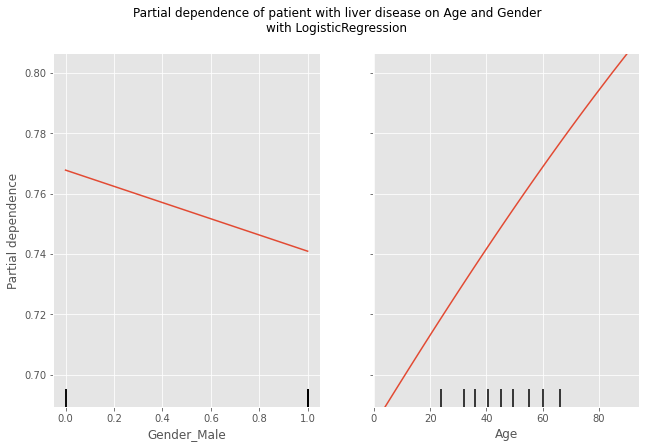

In [40]:
clf_name = models[0][0] # the classifier name
clf = models[0][1] # the classifier itself

features = [0, 3]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of patient with liver disease on Age and Gender\n"
              "with {}".format(clf_name))
fig.set_size_inches(10.5, 6.5)
fig.subplots_adjust(hspace=0.3)

The above one-way PDP tell us about the interaction between the target response and the target feature (e.g. linear, non-linear). Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

The above one-way PDPs clearly show linear relationship

- Left plot: The male (`Gender_Male = 1`) has lower chance to get liver disease than the female (`Gender_Male = 0`).
- Right plot : The olderly has higher chance to get liver disease.

We could also plot a 2-way PDP, for example, visualizing the effect of the joint of `Age` and `Gender_Male` on the response by specifying a `tuple` that contains the indexes of them.

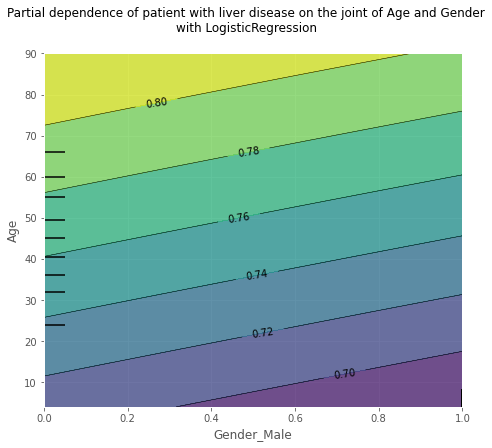

In [41]:
features = [(0, 3)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of patient with liver disease on the joint of Age and Gender\n"
              "with {}".format(clf_name))
fig.set_size_inches(7.5, 6.5)
fig.subplots_adjust(hspace=0.3)

We could also plot the one-way and two-way PDP together. 

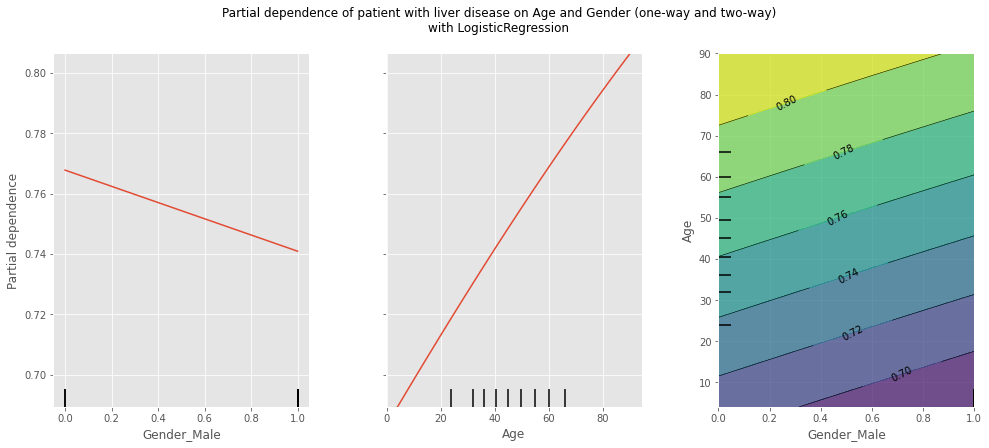

In [42]:
features = [0, 3, (0, 3)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of patient with liver disease on Age and Gender (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3, hspace=0.9)

### Example: PDP for DecisionTree
Let's plot the effect (one-way and two-way) of `Age` and `Gender_Male` for `RandomForest`.

In [43]:
models[2]

('RandomForest',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=123,
                        verbose=0, warm_start=False))

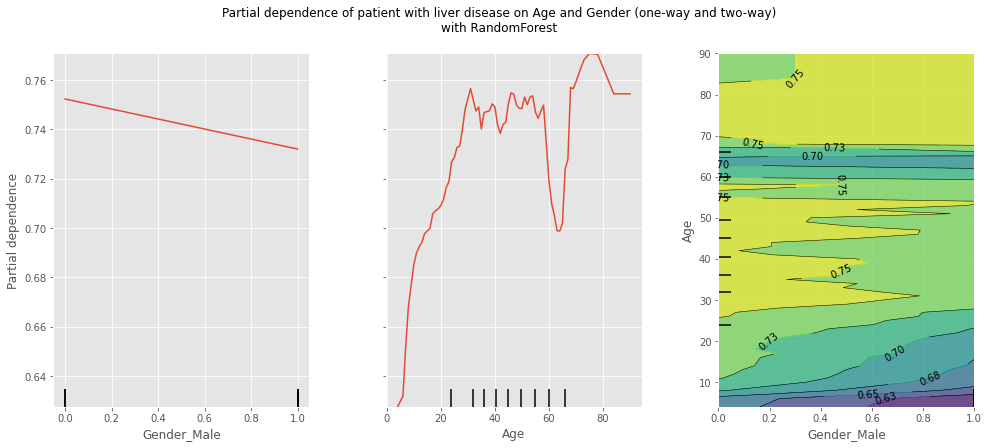

In [44]:
clf_name = models[2][0]
clf = models[2][1]

features = [0, 3, (0, 3)]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of patient with liver disease on Age and Gender (one-way and two-way)\n"
              "with {}".format(clf_name))
fig.set_size_inches(16.5, 6.5)
fig.subplots_adjust(wspace = 0.3)

The above plot shows:

- Left plot (one-way `Gender_Male`) shows that the male (`Gender_Male = 1`) has lower chance to get liver disease than the female (`Gender_Male = 0`).
- Middle plot (one-way `Age`) shows a non-linear relationship between age and the probability of patient with liver disease. It also shows that people with age < 20 have lowest chance to get liver diease. 30-year-old to 60-year-old seemly have the similar chance to get liver diease. 70-year-old to 80-year-old have the highest chance to get liver disease.

- Right plot (two-way of `Gender_Male` and `Age`) shows that for young people (age < 20), the chance of getting liver disease has a strong dependence on gender; for people (age > 20) we could see that the chance of getting liver disease seems to be independent of the gender.

## Permutation Feature Importance 

Previous section shows that Partial Dependence Plots could present how a feature affects predictions. In this section, we focus on another basic question:  What features have the biggest impact on predictions?

This concept is called **feature importance**.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

We'll focus on **Permutation Feature Importance**. Compared to most other approaches, Permutation Feature Importance is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

The Permutation Feature Importance is defined to be the **decrease in a model score** when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 

The above definition might be confused. Here is a clear example to show you how it works: https://www.kaggle.com/dansbecker/permutation-importance



In [45]:
# import permutation function
from sklearn.inspection import permutation_importance

`permutation_importance` has the following arguments:

- `estimator`: your fitted model/classifier.
- `X` : training or hold-out testing data
- `y` : target values corresponding to X
- `scoring` : model score
- `n_repeats` : the number of times to shuffle the features
- `random_state` : for reproducibility

NOTE-1: if you are training `Regression` models, the `scoring` could be one of the followings:

- `"neg_mean_squared_error"`: MSE score
- `"r2"` : $R^2$ score
- ... For more options: https://scikit-learn.org/stable/modules/model_evaluation.html

NOTE-2: if you are training `Classification` models, the `scoring` could be one of the followings:

- `"accuracy"`: Accuracy score
- `"f1_micro"` : F1 score (micro version)
- ... For more options: https://scikit-learn.org/stable/modules/model_evaluation.html



### Example: Permutation Feature Importance for Logistic Regression

#### Permutation Feature Importance on Training Data
Let's first plot the Permutation Feature Importance on **training data** with the trained Logistic Regression . 


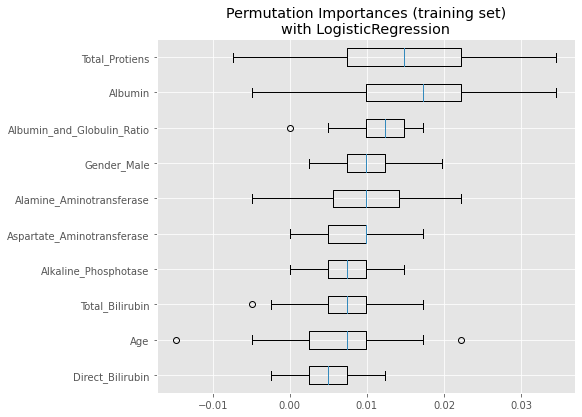

In [46]:

clf_name = models[0][0]
clf = models[0][1]
result = permutation_importance(estimator=clf, 
                                X=X_train_transform, 
                                y=y_train_transform, 
                                scoring="accuracy",
                                n_repeats=50,
                                random_state=123)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(new_cols)[sorted_idx])
ax.set_title("Permutation Importances (training set)\n"
            "with {}".format(clf_name))

fig.set_size_inches(7.5, 6.5)
plt.show()

**Interpretation**

- The values towards the top are the most important features, and those towards the bottom matter least.

- The values show how much model performance decreased with a random shuffling (in this case, using `accuracy` as the performance metric).

The above plot shows that `Total_Protiens` is the most important feature in the Logistic Regression model because once we shuffle the `Total_Protiens` column of the training data, leaving the target and all other columns in place, the **decrease** of the `accuracy` score of predictions is around 0.01. 

#### Permutation Feature Importance on Hold-out Testing Data

Permutation importances can either be computed on the training set or an held-out testing or validation set. 
- Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. 

- Features that are important on the training set but not on the held-out set might cause the model to overfit.

Let's plot the Permutation Feature Importance on **hold-out testing data**

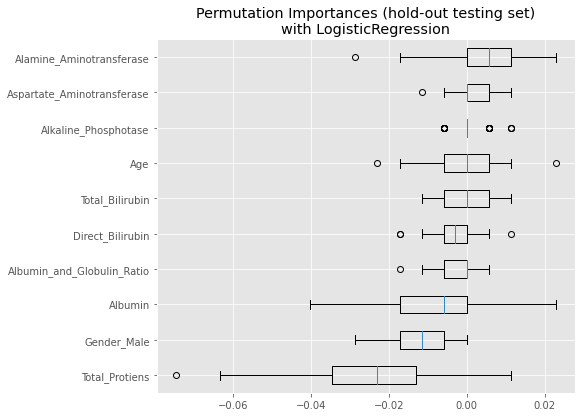

In [47]:
result = permutation_importance(estimator=clf, 
                                X=X_test_transform, 
                                y=y_test_transform, 
                                scoring="accuracy",
                                n_repeats=50,
                                random_state=123)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(new_cols)[sorted_idx])
ax.set_title("Permutation Importances (hold-out testing set)\n"
            "with {}".format(clf_name))
fig.set_size_inches(7.5, 6.5)

plt.show()

In the above Permutation Feature Importance plot, we could see that `Alamine_Aminotransferase` is the most important feature while `Total_Protiens` is the least important one. Compared with the Permutation Importance plot on training data, the model might have overfitted on `Total_Protiens`. The reason why I say "might have overfitted" is as follows:

`Total_Protiens` has negative values for permutation importances. In this case, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

**NOTE**

Note that features that are deemed non-important for some model with a low predictive performance could be highly predictive for a model that generalizes better. The conclusions should always be drawn in the context of the specific model under inspection and cannot be automatically generalized to the intrinsic predictive value of the features by them-selves. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances.
